# Proyek Klasifikasi Gambar: Vegetable Image Dataset
- **Nama:** Firdaus Khotibul Zickrian
- **Email:** espejodaniel50@gmail.com
- **ID Dicoding:** Firdaus Khotibul Zickrian

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
from PIL import Image
!pip install tensorflowjs
import tensorflowjs as tfjs
import shutil
from google.colab import files


## Data Preparation

### Data Loading

In [2]:
# Path folder dataset setelah unzip
dataset_folder = "/content/vegetables/Vegetable Images"

if os.path.exists(dataset_folder):
    print("Dataset sudah ada, skip proses download dan unzip.")
else:
    print("Dataset belum ada, mulai download...")

    # SETUP API
    os.environ['KAGGLE_USERNAME'] = "firdauskz"
    os.environ['KAGGLE_KEY'] = "KGAT_c84bf9823623b2710e422d428e8037f3"

    !pip install kaggle

    # DOWNLOAD DATASET
    !kaggle datasets download -d misrakahmed/vegetable-image-dataset
    !mkdir -p vegetables
    !unzip -o vegetable-image-dataset.zip -d vegetables

    print("Dataset berhasil di-download dan diekstrak!")

# Atur base_path setelah dipastikan ada folder
base_path = dataset_folder
print("\nIsi folder utama:", os.listdir(base_path))




Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: vegetables/Vegetable Images/train/Radish/0004.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0005.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0006.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0007.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0008.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0009.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0010.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0011.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0012.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0013.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0014.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0015.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0016.jpg  
  inflating: vegetables/Vegetable Images/train/Radish/0017.jpg  
  inflating: vegetables/Vegetab

In [3]:
# Path dataset setelah di-unzip dari Kaggle
base_path = "/content/vegetables/Vegetable Images"

train_path = os.path.join(base_path, "train")
val_path   = os.path.join(base_path, "validation")
test_path  = os.path.join(base_path, "test")

In [4]:
for cls in sorted(os.listdir(train_path)):
    n_images = len(os.listdir(os.path.join(train_path, cls)))
    print(f"{cls:15s}: {n_images} images")


Bean           : 1000 images
Bitter_Gourd   : 1000 images
Bottle_Gourd   : 1000 images
Brinjal        : 1000 images
Broccoli       : 1000 images
Cabbage        : 1000 images
Capsicum       : 1000 images
Carrot         : 1000 images
Cauliflower    : 1000 images
Cucumber       : 1000 images
Papaya         : 1000 images
Potato         : 1000 images
Pumpkin        : 1000 images
Radish         : 1000 images
Tomato         : 1000 images


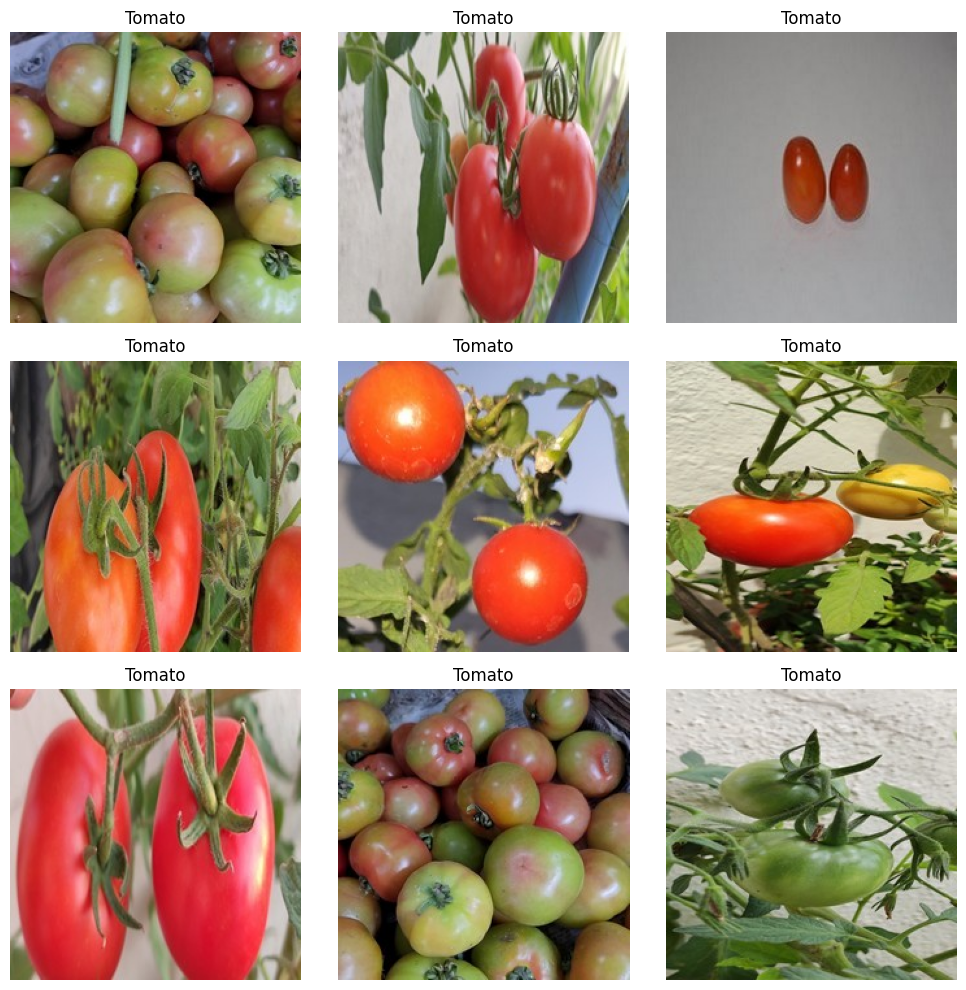

In [5]:
# Pilih kelas secara acak
sample_class = random.choice(os.listdir(train_path))

# Ambil sampai 9 gambar dari kelas tersebut
sample_files = os.listdir(os.path.join(train_path, sample_class))
sample_files = [f for f in sample_files if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Pastikan jumlah minimal
sample_files = sample_files[:9]

# Tampilkan
plt.figure(figsize=(10,10))
for i, fname in enumerate(sample_files):
    img_path = os.path.join(train_path, sample_class, fname)
    img = Image.open(img_path)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(sample_class)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [6]:
# menghitung jumlah gambar dalam subfolder
def count_images(path):
    total = 0
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        total += len(os.listdir(cls_path))
    return total

# Hitung jumlah data per set
train_count = count_images(train_path)
val_count   = count_images(val_path)
test_count  = count_images(test_path)

# Hitung jumlah kelas
num_classes = len(os.listdir(train_path))

print("Jumlah kelas:", num_classes)
print("Jumlah gambar training   :", train_count)
print("Jumlah gambar validation :", val_count)
print("Jumlah gambar testing    :", test_count)

# tampilkan nama kelas
print("\nDaftar kelas:")
for cls in sorted(os.listdir(train_path)):
    print("-", cls)

Jumlah kelas: 15
Jumlah gambar training   : 15000
Jumlah gambar validation : 3000
Jumlah gambar testing    : 3000

Daftar kelas:
- Bean
- Bitter_Gourd
- Bottle_Gourd
- Brinjal
- Broccoli
- Cabbage
- Capsicum
- Carrot
- Cauliflower
- Cucumber
- Papaya
- Potato
- Pumpkin
- Radish
- Tomato


In [7]:
for cls in sorted(os.listdir(train_path)):
    print(cls, len(os.listdir(os.path.join(train_path, cls))))


Bean 1000
Bitter_Gourd 1000
Bottle_Gourd 1000
Brinjal 1000
Broccoli 1000
Cabbage 1000
Capsicum 1000
Carrot 1000
Cauliflower 1000
Cucumber 1000
Papaya 1000
Potato 1000
Pumpkin 1000
Radish 1000
Tomato 1000


In [8]:
# Ukuran input gambar
img_size = (224, 224)
batch_size = 32

# Data Augmentation hanya pada data train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode="nearest"
)

# VALIDATION & TEST
val_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat Generator
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Tampilkan kelas
print("Class indices:", train_gen.class_indices)
num_classes = train_gen.num_classes


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Class indices: {'Bean': 0, 'Bitter_Gourd': 1, 'Bottle_Gourd': 2, 'Brinjal': 3, 'Broccoli': 4, 'Cabbage': 5, 'Capsicum': 6, 'Carrot': 7, 'Cauliflower': 8, 'Cucumber': 9, 'Papaya': 10, 'Potato': 11, 'Pumpkin': 12, 'Radish': 13, 'Tomato': 14}


## Modelling

In [9]:
model = keras.Sequential([
    # Input Layer
    layers.InputLayer(input_shape=(224, 224, 3)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten & Dense
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,686,223 (36.95 MB)

 Trainable params: 9,686,223 (36.95 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
epochs = 25

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 225s 459ms/step - accuracy: 0.2992 - loss: 2.0408 - val_accuracy: 0.6357 - val_loss: 1.0550 - learning_rate: 0.0010
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 434ms/step - accuracy: 0.6016 - loss: 1.1569 - val_accuracy: 0.7663 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 434ms/step - accuracy: 0.7433 - loss: 0.7987 - val_accuracy: 0.8433 - val_loss: 0.4815 - learning_rate: 0.0010
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 438ms/step - accuracy: 0.7748 - loss: 0.6752 - val_accuracy: 0.8857 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 436ms/step - accuracy: 0.8257 - loss: 0.5318 - val_accuracy: 0.9353 - val_loss: 0.2157 - learning_rate: 0.0010
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 436ms/step - accuracy: 0.8576 - loss: 0.4439 - val_accuracy: 0.9503 - val_loss: 0.1718 - learning_rate: 0.0010
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 434ms/step - accura

## Evaluasi dan Visualisasi

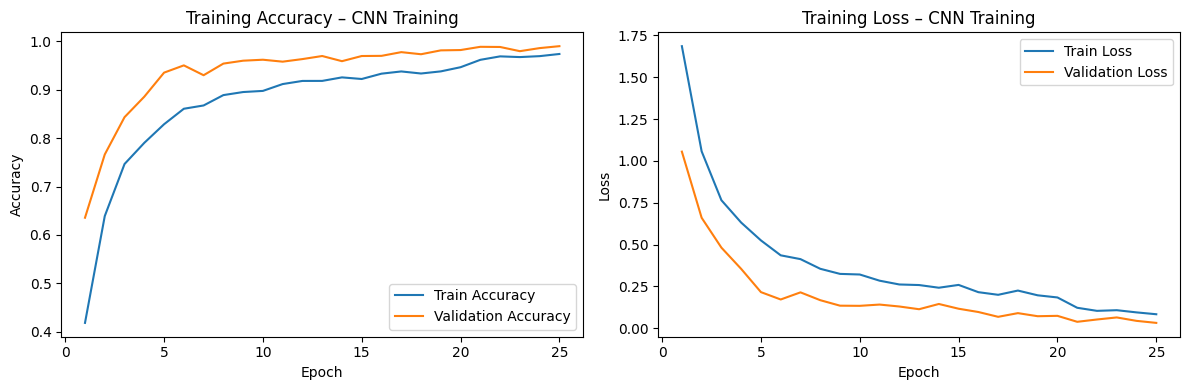

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9917 - loss: 0.0271

Test Accuracy : 0.9913
Test Loss     : 0.0289
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


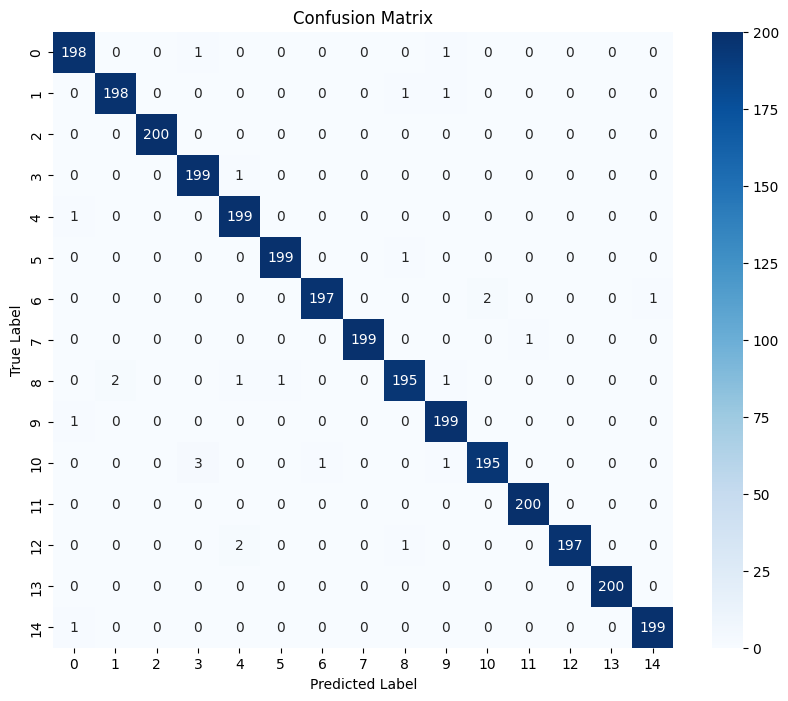


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bean       0.99      0.99      0.99       200
Bitter_Gourd       0.99      0.99      0.99       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       0.98      0.99      0.99       200
    Broccoli       0.98      0.99      0.99       200
     Cabbage       0.99      0.99      0.99       200
    Capsicum       0.99      0.98      0.99       200
      Carrot       1.00      0.99      1.00       200
 Cauliflower       0.98      0.97      0.98       200
    Cucumber       0.98      0.99      0.99       200
      Papaya       0.99      0.97      0.98       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      0.98      0.99       200
      Radish       1.00      1.00      1.00       200
      Tomato       0.99      0.99      0.99       200

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
we

In [12]:
# FUNGSI PLOT HISTORY
def plot_history(hist, title_suffix=""):
    acc      = hist.history['accuracy']
    val_acc  = hist.history.get('val_accuracy', None)
    loss     = hist.history['loss']
    val_loss = hist.history.get('val_loss', None)

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Accuracy")
    if val_acc is not None:
        plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.title(f"Training Accuracy {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.title(f"Training Loss {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# PLOT TRAINING
plot_history(history, "– CNN Training")

# EVALUASI PADA TEST SET
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy : {test_acc:.4f}")
print(f"Test Loss     : {test_loss:.4f}")

# CONFUSION MATRIX & REPORT

# Label asli dan prediksi
y_true = test_gen.classes
y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("\nCLASSIFICATION REPORT:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_gen.class_indices.keys())
))


## Konversi Model

In [14]:
base_dir = "submission"

os.makedirs(f"{base_dir}/saved_model", exist_ok=True)
os.makedirs(f"{base_dir}/tflite", exist_ok=True)
os.makedirs(f"{base_dir}/tfjs_model", exist_ok=True)

# SAVE MODEL → SavedModel
saved_model_path = f"{base_dir}/saved_model"
model.export(saved_model_path)   # <-- FIX !!!
print("✔ SavedModel berhasil dibuat!")

# SAVE MODEL → TFLITE
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

with open(f"{base_dir}/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

print("✔ TFLite model berhasil dibuat!")


# SAVE LABELS
labels = list(train_gen.class_indices.keys())
with open(f"{base_dir}/tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

print("✔ label.txt berhasil dibuat!")

# SAVE MODEL → TFJS
tfjs.converters.save_keras_model(model, f"{base_dir}/tfjs_model")

print("✔ TFJS model berhasil dibuat!")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  138543132996624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543132997200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543132998736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543132998544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543132995664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543132999504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543132996816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543132998928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543132999120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138543032861712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1385431

✔ TFLite model berhasil dibuat!
✔ label.txt berhasil dibuat!
failed to lookup keras version from the file,
    this is likely a weight only file
✔ TFJS model berhasil dibuat!


In [15]:
shutil.make_archive("submission", "zip", "submission")


'/content/submission.zip'

In [16]:
files.download("submission.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

✔ SavedModel loaded (TF runtime mode)
Hasil Inferensi:
Prediksi index : 14
Prediksi label : Tomato
Confidence     : 0.9998171925544739


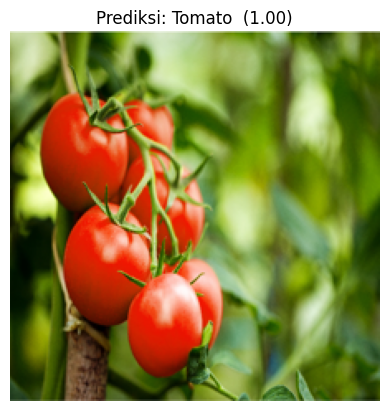

In [18]:
# LOAD SavedModel (format baru)
loaded = tf.saved_model.load("submission/saved_model")
infer = loaded.signatures["serving_default"]
print("✔ SavedModel loaded (TF runtime mode)")

# Fungsi preprocessing
def load_image(path, img_size=(224, 224)):
    img = Image.open(path).convert("RGB")
    img = img.resize(img_size)
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, 0)
    return img, arr.astype(np.float32)

# LOAD gambar
image_path = "tomattest.jpg"
img_show, img_input = load_image(image_path)

# Konversi ke tensor
input_tensor = tf.convert_to_tensor(img_input)

# INFERENCE
output = infer(input_tensor)
pred = list(output.values())[0].numpy()
pred_idx = np.argmax(pred)

# LABEL
labels = list(train_gen.class_indices.keys())

print("===================================")
print("Hasil Inferensi:")
print("Prediksi index :", pred_idx)
print("Prediksi label :", labels[pred_idx])
print("Confidence     :", float(np.max(pred)))
print("===================================")

plt.imshow(img_show)
plt.title(f"Prediksi: {labels[pred_idx]}  ({np.max(pred):.2f})")
plt.axis("off")
plt.show()


✔ SavedModel loaded (TF runtime mode)
Hasil Inferensi:
Prediksi index : 4
Prediksi label : Broccoli
Confidence     : 0.7363937497138977


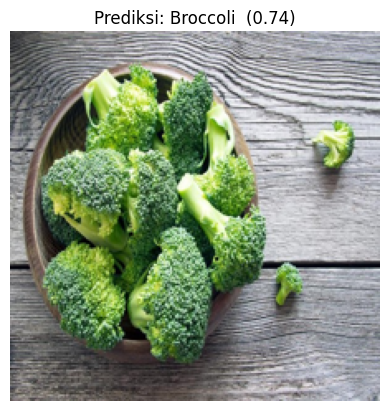

In [19]:
# LOAD SavedModel (format baru)
loaded = tf.saved_model.load("submission/saved_model")
infer = loaded.signatures["serving_default"]
print("✔ SavedModel loaded (TF runtime mode)")

# Fungsi preprocessing
def load_image(path, img_size=(224, 224)):
    img = Image.open(path).convert("RGB")
    img = img.resize(img_size)
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, 0)
    return img, arr.astype(np.float32)

# LOAD gambar
image_path = "brocolitest.jpg"
img_show, img_input = load_image(image_path)

# Konversi ke tensor
input_tensor = tf.convert_to_tensor(img_input)

# INFERENCE
output = infer(input_tensor)
pred = list(output.values())[0].numpy()
pred_idx = np.argmax(pred)

# LABEL
labels = list(train_gen.class_indices.keys())

print("===================================")
print("Hasil Inferensi:")
print("Prediksi index :", pred_idx)
print("Prediksi label :", labels[pred_idx])
print("Confidence     :", float(np.max(pred)))
print("===================================")

plt.imshow(img_show)
plt.title(f"Prediksi: {labels[pred_idx]}  ({np.max(pred):.2f})")
plt.axis("off")
plt.show()

✔ SavedModel loaded (TF runtime mode)
Hasil Inferensi:
Prediksi index : 11
Prediksi label : Potato
Confidence     : 0.5386725664138794


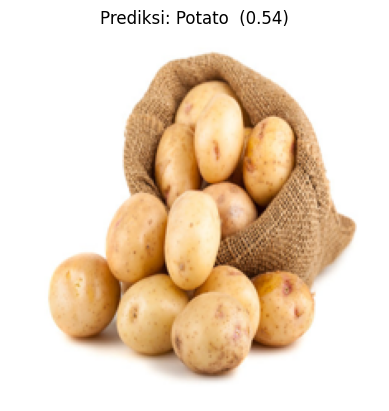

In [23]:
# LOAD SavedModel (format baru)
loaded = tf.saved_model.load("submission/saved_model")
infer = loaded.signatures["serving_default"]
print("✔ SavedModel loaded (TF runtime mode)")

# Fungsi preprocessing
def load_image(path, img_size=(224, 224)):
    img = Image.open(path).convert("RGB")
    img = img.resize(img_size)
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, 0)
    return img, arr.astype(np.float32)

# LOAD gambar
image_path = "kentangtes.jpg"
img_show, img_input = load_image(image_path)

# Konversi ke tensor
input_tensor = tf.convert_to_tensor(img_input)

# INFERENCE
output = infer(input_tensor)
pred = list(output.values())[0].numpy()
pred_idx = np.argmax(pred)

# LABEL
labels = list(train_gen.class_indices.keys())

print("===================================")
print("Hasil Inferensi:")
print("Prediksi index :", pred_idx)
print("Prediksi label :", labels[pred_idx])
print("Confidence     :", float(np.max(pred)))
print("===================================")

plt.imshow(img_show)
plt.title(f"Prediksi: {labels[pred_idx]}  ({np.max(pred):.2f})")
plt.axis("off")
plt.show()